In [1]:
%reload_ext memory_profiler
import autograd.numpy as anp
from qoc import grape_schroedinger_discrete
from qoc.standard import (TargetStateInfidelity_manual
                          conjugate_transpose,
                          get_annihilation_operator,
                          get_creation_operator,
                          SIGMA_Z,
                          generate_save_file_path, )
from memory_profiler import profile
import numpy as np

from qutip import (qsave,qload)
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
def test():
    A=np.ones((6000,6000))
    B
    #np.dot(A,np.dot(A,np.dot(A,A,B),B),B)

In [2]:
%memit np.identity(6000)

peak memory: 189.14 MiB, increment: 21.51 MiB


In [2]:
%memit np.ones((6000,6000))

peak memory: 415.20 MiB, increment: 247.49 MiB


In [8]:


# Define the system.
def get_memory_manually(N,l):
    """
    0_transmon_pi.py - This module demonstrates
    a simple example of grape on the schroedinger equation
    using time discrete control parameters to evolve a transmon qubit
    form the ground state to the first excited state.
    """


    HILBERT_SIZE = l
    ANNIHILATION_OPERATOR = get_annihilation_operator(HILBERT_SIZE)
    CREATION_OPERATOR = get_creation_operator(HILBERT_SIZE)
    # E.q. 19 (p. 6) of https://arxiv.org/abs/1904.06560.
    sigmax = ANNIHILATION_OPERATOR + CREATION_OPERATOR
    # E.q. 19 (p. 6) of https://arxiv.org/abs/1904.06560.
    H_SYSTEM_0 = CREATION_OPERATOR*ANNIHILATION_OPERATOR
    # Only real control amplitutdes are supported!
    hamiltonian = lambda controls, time: (H_SYSTEM_0
                                          + controls[0] * sigmax)

    # Define the problem.
    CAVITY_VACUUM = anp.zeros((l, 1))
    CAVITY_ZERO = anp.copy(CAVITY_VACUUM)
    CAVITY_ZERO[0, 0] = 1
    CAVITY_ONE = anp.copy(CAVITY_VACUUM)
    CAVITY_ONE[1, 0] = 1
    CAVITY_VACUUM= anp.zeros((l, 1))

    INITIAL_STATE_0=anp.copy(CAVITY_VACUUM)
    INITIAL_STATE_0[0,0]=1
    TARGET_STATE_0 = anp.copy(CAVITY_VACUUM)
    TARGET_STATE_0[1,0]=1
    INITIAL_STATES = anp.stack((INITIAL_STATE_0,), axis=0)
    TARGET_STATES = anp.stack((TARGET_STATE_0,), axis=0)
    COSTS = [TargetStateInfidelity_manual(TARGET_STATES)]

    # Define the optimization.
    COMPLEX_CONTROLS = False
    CONTROL_COUNT = 1
    EVOLUTION_TIME = 10  # nanoseconds
    CONTROL_EVAL_COUNT = SYSTEM_EVAL_COUNT = N + 1
    ITERATION_COUNT = 2

    # Define output.
    LOG_ITERATION_STEP = 1
    SAVE_ITERATION_STEP = 1
    SAVE_PATH = "./out"
    SAVE_FILE_NAME = "transmon_pi"
    SAVE_FILE_PATH = generate_save_file_path(SAVE_FILE_NAME, SAVE_PATH)
    CONTROL_HAMILTONIAN = [sigmax]

    manual_parameter = {"control_hamiltonian": CONTROL_HAMILTONIAN, "manual_gradient_mode": True,'Hk_approximation':False}

    def main():
        result = grape_schroedinger_discrete(CONTROL_COUNT, CONTROL_EVAL_COUNT,
                                             COSTS, EVOLUTION_TIME, hamiltonian,
                                             INITIAL_STATES, SYSTEM_EVAL_COUNT,
                                             complex_controls=COMPLEX_CONTROLS,
                                             iteration_count=ITERATION_COUNT,
                                             log_iteration_step=LOG_ITERATION_STEP,
                                             manual_parameter=manual_parameter
                                             )
    if __name__ == "__main__":
        main()

def memory_plot_Nfixed(N,l,time_ad,time_ma):
    fig, ax = plt.subplots()
    x = (np.array(l))**2 
    y = np.array(time_ad[0]) 
    fit = np.polyfit(x,y,1)
    ang_coeff = fit[0]
    intercept = fit[1]
    fit_eq = ang_coeff*x + intercept  
    ax.errorbar(x, time_ad[0], yerr = time_ad[1],fmt='o',color='C0',label='Auto-grad average points')
    ax.plot(x, fit_eq,color='C0', alpha = 0.5, label = 'Auto-grad Linear fit')
    print('AD '+"slope is "+str(ang_coeff)+"and intercept is "+str(intercept))
    maximum_ad=int(np.sqrt((976562.5-intercept)/ang_coeff))
    
    x = (np.array(l))**2 
    y = np.array(time_ma[0]) 
    fit = np.polyfit(x,y,1)
    ang_coeff = fit[0]
    intercept = fit[1]
    fit_eq = ang_coeff*x + intercept 
    ax.plot(x, fit_eq,color = 'C1', alpha = 0.5, label = 'Manual Linear fit')
    ax.errorbar(x, time_ma[0], yerr = time_ad[1],fmt='o',color='C1',label='Manual average points')
    print('Manual '+"slope is "+str(ang_coeff)+"and intercept is "+str(intercept))
    ax.legend()
    ax.set_ylabel ( "Memory usage/MiB")
    ax.set_xlabel ('Hilbert space dimension^2')
    ax.set_title('Total number of time step is '+str(N))
    maximum_ma=int(np.sqrt((976562.5-intercept)/ang_coeff))
    print("Manual:For 128GB RAM, Maximum Hilbert space dimension which is independent of total number of time step is "+str(maximum_ma))
    print("AD:For 128GB RAM, Maximum Hilbert space dimension when total number of time step= "+str(N) +' is '+ str(maximum_ad))
    #ax.set_yscale('log')
    #ax.set_xscale('log')
    
    plt.show()
def memory_plot_lfixed(N,l,time_ad,time_ma):
    fig, ax = plt.subplots() 
    x = (np.array(N)) 
    y = np.array(time_ad[0]) 
    fit = np.polyfit(x,y,1)
    ang_coeff = fit[0]
    intercept = fit[1]
    fit_eq = ang_coeff*x + intercept
    ax.errorbar(x, time_ad[0], yerr = time_ad[1],fmt='o',color='C0',label='Auto-grad average points')
    ax.plot(x, fit_eq,color='C0', alpha = 0.5, label = 'Auto-grad Linear fit')
    print('AD '+"slope is "+str(ang_coeff)+"and intercept is "+str(intercept))
    
    x = (np.array(N)) 
    y = np.array(time_ma[0]) 
    fit = np.polyfit(x,y,1)
    ang_coeff = fit[0]
    intercept = fit[1]
    fit_eq = ang_coeff*x + intercept
    ax.errorbar(N, time_ma[0], yerr = time_ad[1],fmt='o',color='C1',label='Manual average points')
    ax.plot(x, fit_eq,color='C1', alpha = 0.5, label = 'Auto-grad Linear fit')
    print('Manual '+"slope is "+str(ang_coeff)+"and intercept is "+str(intercept))
    ax.set_ylabel ( "Memory usage/MiB")
    ax.set_xlabel ('Total time number of time step')
    ax.set_title('Hilbert space dimension is '+str(l))
    #ax.set_yscale('log')
    #ax.set_xscale('log')
    ax.legend()
    plt.savefig('memory_lfixed')
    plt.show()




In [3]:
N_=10
mem_ma_Nfixed=[[],[]]
h_dims=[100,150,200,250,300]
for dim in h_dims:
    mem_temp = %memit -r10 -i0.0001 -o get_memory_manually(N_,dim)
    mem_temp=np.array(mem_temp.mem_usage)
    mem_ma_Nfixed[0].append(np.average(mem_temp))
    mem_ma_Nfixed[1].append(np.std(mem_temp))

        

iter   |   total error  |    grads_l2   
  0    | 6.32120559e-01 | 2.94652635e-15
  1    | 6.32120559e-01 | 4.05644134e-09
iter   |   total error  |    grads_l2   
  0    | 6.32120559e-01 | 2.94652635e-15
  1    | 6.32120559e-01 | 4.05644134e-09
iter   |   total error  |    grads_l2   
  0    | 6.32120559e-01 | 2.94652635e-15
  1    | 6.32120559e-01 | 4.05644134e-09
iter   |   total error  |    grads_l2   
  0    | 6.32120559e-01 | 2.94652635e-15
  1    | 6.32120559e-01 | 4.05644134e-09
iter   |   total error  |    grads_l2   
  0    | 6.32120559e-01 | 2.94652635e-15
  1    | 6.32120559e-01 | 4.05644134e-09
iter   |   total error  |    grads_l2   
  0    | 6.32120559e-01 | 2.94652635e-15
  1    | 6.32120559e-01 | 4.05644134e-09
iter   |   total error  |    grads_l2   
  0    | 6.32120559e-01 | 2.94652635e-15
  1    | 6.32120559e-01 | 4.05644134e-09
iter   |   total error  |    grads_l2   
  0    | 6.32120559e-01 | 2.94652635e-15
  1    | 6.32120559e-01 | 4.05644134e-09
iter   |   total

  1    | 6.32120559e-01 | 4.05644134e-09
iter   |   total error  |    grads_l2   
  0    | 6.32120559e-01 | 2.94652635e-15
  1    | 6.32120559e-01 | 4.05644134e-09
peak memory: 270.97 MiB, increment: 42.34 MiB


In [4]:
mem_ad_Nfixed=qload('mem_Nfixed')

Loaded list object.


AD slope is 0.0029817378631498445and intercept is 219.31007740825686
Manual slope is 0.0005838180905963286and intercept is 219.58771717316503
Manual:For 128GB RAM, Maximum Hilbert space dimension which is independent of total number of time step is 40894
AD:For 128GB RAM, Maximum Hilbert space dimension when total number of time step= 10 is 18095


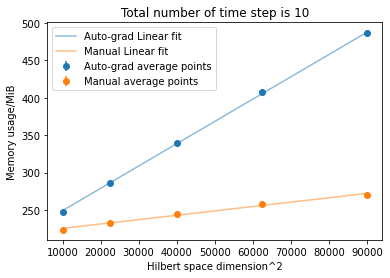

In [9]:
memory_plot_Nfixed(N_,h_dims,mem_ad_Nfixed,mem_ma_Nfixed)

In [ ]:
qsave([N_,h_dims,mem_ad_Nfixed,mem_ma_Nfixed],'memory_Nfiexd')

In [3]:
N=[10,30,50,70]
mem_ma_lfixed=[[],[]]
l=200
mem_temp = %memit -r10 -i0.0001 -o get_memory_manually(N[0],l)
mem_temp=np.array(mem_temp.mem_usage)
print(np.average(mem_temp))
print(np.std(mem_temp))

iter   |   total error  |    grads_l2   
  0    | 6.32120559e-01 | 2.94652635e-15
  1    | 6.32120559e-01 | 4.05644134e-09
iter   |   total error  |    grads_l2   
  0    | 6.32120559e-01 | 2.94652635e-15
  1    | 6.32120559e-01 | 4.05644134e-09
iter   |   total error  |    grads_l2   
  0    | 6.32120559e-01 | 2.94652635e-15
  1    | 6.32120559e-01 | 4.05644134e-09
iter   |   total error  |    grads_l2   
  0    | 6.32120559e-01 | 2.94652635e-15
  1    | 6.32120559e-01 | 4.05644134e-09
iter   |   total error  |    grads_l2   
  0    | 6.32120559e-01 | 2.94652635e-15
  1    | 6.32120559e-01 | 4.05644134e-09
iter   |   total error  |    grads_l2   
  0    | 6.32120559e-01 | 2.94652635e-15
  1    | 6.32120559e-01 | 4.05644134e-09
iter   |   total error  |    grads_l2   
  0    | 6.32120559e-01 | 2.94652635e-15
  1    | 6.32120559e-01 | 4.05644134e-09
iter   |   total error  |    grads_l2   
  0    | 6.32120559e-01 | 2.94652635e-15
  1    | 6.32120559e-01 | 4.05644134e-09
iter   |   total

In [4]:
mem_ma_lfixed=[[242.251953125,233.971875,232.42890625,232.39921875],[0.22,0.17328787183019329,0.18,0.16]]

In [7]:
qsave([N,l,mem_ad_lfixed,mem_ma_lfixed],'memory_lfiexd')

In [6]:
mem_ad_lfixed=qload('mem_lfixed')

Loaded list object.


AD slope is 11.105296875000002and intercept is 226.33753906250016
Manual slope is -0.15550585937500028and intercept is 241.48322265625


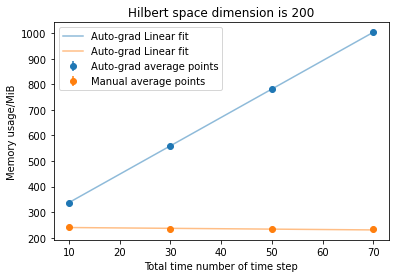

In [10]:
memory_plot_lfixed(N,l,mem_ad_lfixed,mem_ma_lfixed)